In [0]:
googlecolab = False

if googlecolab:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
    !pip install Pillow==4.1.1

In [0]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

## Hyperpameters

Define the hyperparameters. You can play with those later.

In [4]:
## Data loading

workers = 4 # Number of workers for dataloader (/!\ set to 4 when you're done debugging)

## Architecture

arch = 'cDCGAN' # or cGAN
nz = 100 # Size of z latent vector (i.e. size of generator input)µ
ndf = 32 # Base size of feature maps in discriminator
ngf = 32 # Base size of feature maps in generator

## Optimization

lrD = 0.0002 # Learning rate for the discriminator
lrG = 0.0002 # Learning rate for the generator
beta1G = 0.5 # Momentum beta1 for the discriminator
beta1D = 0.5 # Momentum beta1 for the generator

## Training

batch_size = 128 # Images per batch
nb_update_D = 1 # Number of sub-steps of discriminator optim. at each step
nb_update_G = 1 # Number of sub-steps of generator optim. at each step
#steps = 8000 # Number of global steps in the training loop
nb_epochs = 20 # Number of epochs, leave "None" if you want to set the number of "steps" (i.e. batches)


if nb_epochs is None:
    nb_epochs = (steps * batch_size) / (nb_update_D * 50000)
else:
    steps = int(nb_epochs * nb_update_D * 50000 / batch_size)
print("Doing %.1f epochs in %d steps" % (nb_epochs, steps))
steps_per_epoch = int(steps / nb_epochs)

Doing 20.0 epochs in 7812 steps


# Dataset

Download and load the dataset. Nothing to do here.

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 29200958.61it/s]                            


Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw


32768it [00:00, 454939.20it/s]
  1%|          | 16384/1648877 [00:00<00:11, 146069.00it/s]

Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw


1654784it [00:00, 7723076.59it/s]                            
8192it [00:00, 177878.58it/s]


Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw
Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw
Processing...
Done!


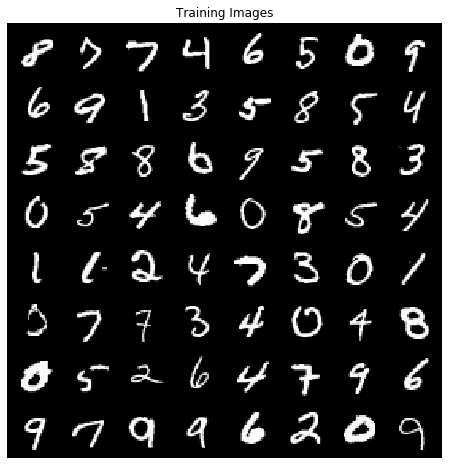

In [5]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataroot = '/tmp/mnist'
transform = transforms.Compose([
        transforms.Pad(2),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])
dataset = dset.MNIST(dataroot, train=True, download=True, transform=transform)
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Model architectures

## Discriminator

Input: Image $x \in \mathbb{R}^{32\times 32\times 1}$  
Output: "Real" image probability $\in [0,1]$

## Generator

Input: Random "noise" $z \in \mathbb{R}^{\text{nz}}$  
Output: Generated image $\tilde x \in \mathbb{R}^{32\times 32\times 1}$


In [0]:
# cDCGAN

if arch == 'cDCGAN':
    
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.emb_x = nn.Sequential(
               nn.Conv2d(1, 64,4, stride=2, padding=1),
               nn.LeakyReLU(negative_slope=0.02)
            )
            self.emb_y = nn.Sequential(
               nn.Conv2d(10, 64,4, stride=2, padding=1),
               nn.LeakyReLU(negative_slope=0.02)
            )
            self.emb_xy = nn.Sequential(
                nn.Conv2d(128, 256,4, stride=2, padding=1),
                nn.BatchNorm2d(256),                             
                nn.LeakyReLU(negative_slope=0.02),
                nn.Conv2d(256, 512,4, stride=2, padding=1),
                nn.BatchNorm2d(512),                             
                nn.LeakyReLU(negative_slope=0.02),
                nn.Conv2d(512, 1,4, stride=2, padding=0),
                nn.Sigmoid()
            )

        def forward(self, x, y):
            x_emb=self.emb_x(x)
            y_exp=y.expand(-1,10,32,32)
            y_emb=self.emb_y(y_exp)
            xy=torch.cat((y_emb,x_emb),dim=1)
            o=self.emb_xy(xy)
            return o



    class Generator(nn.Module):
        def __init__(self):
            super(Generator, self).__init__()
            self.emb_z = nn.Sequential(
                nn.ConvTranspose2d(100, 256,4, stride=1, padding=0),
                nn.BatchNorm2d(256),                             
                nn.ReLU()
            )
            self.emb_y = nn.Sequential(
                nn.ConvTranspose2d(10, 256,4, stride=1, padding=0),
                nn.BatchNorm2d(256),                             
                nn.ReLU()
            )
            self.emb_zy = nn.Sequential(
                nn.ConvTranspose2d(512, 256,4, stride=2, padding=1),
                nn.BatchNorm2d(256),                             
                nn.ReLU(),
                nn.ConvTranspose2d(256, 128,4, stride=2, padding=1),
                nn.BatchNorm2d(128),                             
                nn.ReLU(),
                nn.ConvTranspose2d(128, 1,4, stride=2, padding=1),
                nn.Tanh()
            )

        def forward(self, z, y):
            z_emb=self.emb_z(z)
            y_emb=self.emb_y(y)
            zy=torch.cat((y_emb,z_emb),dim=1)
            o=self.emb_zy(zy)
            return o

In [0]:
# cGAN

if arch == 'cGAN':
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.emb_x = nn.Sequential(
                # TODO
            )
            self.emb_y = nn.Sequential(
                # TODO
            )
            self.emb_xy = nn.Sequential(
                # TODO
            )

        def forward(self, x, y):
            #TODO
            return o



    class Generator(nn.Module):
        def __init__(self):
            super(Generator, self).__init__()
            self.emb_z = nn.Sequential(
                # TODO
            )
            self.emb_y = nn.Sequential(
                # TODO
            )
            self.emb_zy = nn.Sequential(
                # TODO
            )

        def forward(self, z, y):
            # Remove unused dimensions in non-conv model
            z = z.view(z.shape[0], -1) z[:, :, 0, 0]
            y = y.view(y.shape[0], -1)
            
            # TODO
            return o

In [64]:
# Create the models
netG = Generator().to(device)
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
netG.apply(weights_init)
netD.apply(weights_init)

# Print the models
print(netG)
print(netD)

Generator(
  (emb_z): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (emb_y): Sequential(
    (0): ConvTranspose2d(10, 256, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (emb_zy): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Tanh()
  )
)
Discriminator(
  (emb_x): Sequential(
    (0): Conv2d(1, 64, kernel_si

In [65]:
# TODO test you models to check if they 
z = torch.zeros(10, nz, 1, 1).to(device)
x = torch.zeros(10, 1, 32, 32).to(device)
y = torch.randn(10, 10, 1, 1).to(device)
print(netG(z, y).shape) # expected: [10, 1, 32, 32]
print(netD(x, y).shape) # expected: [10, 1, 1, 1]

torch.Size([10, 1, 32, 32])
torch.Size([10, 1, 1, 1])


# Optimization and training

Here we will define:
* Our prior $P(z)$ that we use to sample random "noise". We will use a Gaussian distribution.
* The criterion that will be used to train the discriminator, and indirectly the generator. We will use the binary cross-entropy.
* The optimizers of both models. We will use the Adam optimizer.

In [0]:
# Prior P(z). Returns a Gaussian random tensor of shape (batch_size, nz, 1, 1)
def get_noise(batch_size):
    noise =torch.normal(mean=0,std=1,size=(batch_size, nz, 1, 1))
    return noise.to(device)

# Returns a random vector of one-hot encoding of shape (batch_size, 10, 1, 1)
def get_fixed_y(batch_size):
    y = torch.zeros(batch_size, 10, 1, 1, device=device)
    n = batch_size // 10
    for i in range(10):
        y[i*n:i*n+n, i, :, :].fill_(1)
    return y

# Create the criterion function that will take (y_hat, y) as input
criterion = nn.BCELoss()

# Setup Adam optimizers for D and G
optimizerD = torch.optim.Adam(netD.parameters(),betas=(beta1D, .999),lr=lrD)# TODO
optimizerG = torch.optim.Adam(netG.parameters(),betas=(beta1G, .999),lr=lrG) # TODO

### Data format / batch creation functions

`r_real` and `r_fake` are targets for the disriminator's criterion

In [0]:
# Data format / batch creation functions

fixed_noise = get_noise(100) # Create a fixed random vector sampled from a Gaussian, will be used during train for viz
fixed_y = get_fixed_y(100)
real_label = 1
fake_label = 0
iterator = iter(dataloader)

def onehot(data, nclass=10):
    bsize = data.shape[0]
    y = torch.zeros(bsize, nclass)
    y.scatter_(1, data.unsqueeze(1), 1)
    y = y.unsqueeze(2).unsqueeze(3)
    return y

# returns a batch of real images from the dataset (iterates infinitely on the dataset)
def get_batch_real():
    global iterator
    try:
        x_real, y_real = next(iterator)
    except:
        iterator = iter(dataloader)
        x_real, y_real = next(iterator)
    x_real = x_real.to(device)
    y_real = onehot(y_real).to(device)
    r_real = torch.full((x_real.size(0),), real_label, device=device)
    return x_real, y_real, r_real

# returns a batch of generated images and training targets y_fake
# Note that the targets y_fake will be different is train_G is True or False
def get_batch_fake(y_real, train_G=False):
    z = torch.randn(y_real.shape[0], nz, 1, 1, device=device)
    x_fake = netG(z, y_real)
    if train_G:
        r_fake =torch.ones(batch_size) # TODO
    else:
        r_fake = torch.zeros(batch_size) # TODO
    return x_fake, y_real, r_fake

### Training Loop

**Reminder:** when your training loop starts to work, change the `workers` variable to 4 and rerun your notebook

In [0]:
img_list = []
G_losses = []
D_losses = []

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[    0/ 7812]	Loss_D: 2.0539	Loss_G: 5.7268	D(x): 0.7993	D(G(z)): 0.7351


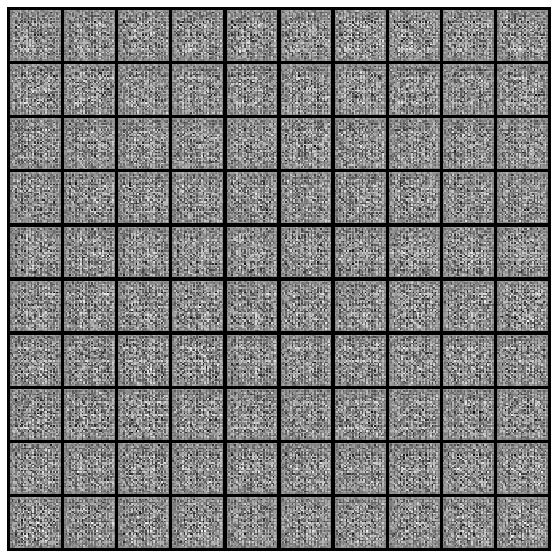

[   25/ 7812]	Loss_D: 0.5179	Loss_G: 1.0169	D(x): 0.6335	D(G(z)): 0.0114
[   50/ 7812]	Loss_D: 1.7236	Loss_G: 6.9794	D(x): 0.9888	D(G(z)): 0.8066
[   75/ 7812]	Loss_D: 1.8086	Loss_G: 2.3237	D(x): 0.3006	D(G(z)): 0.0044
[  100/ 7812]	Loss_D: 0.9750	Loss_G: 5.9222	D(x): 0.9393	D(G(z)): 0.5432


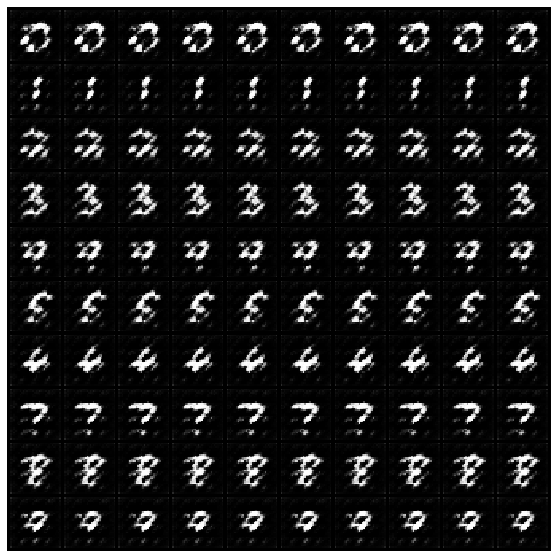

[  125/ 7812]	Loss_D: 0.9136	Loss_G: 5.9205	D(x): 0.8883	D(G(z)): 0.5164
[  150/ 7812]	Loss_D: 0.1873	Loss_G: 3.5988	D(x): 0.9218	D(G(z)): 0.0942
[  175/ 7812]	Loss_D: 0.1917	Loss_G: 3.4738	D(x): 0.9395	D(G(z)): 0.1148
[  200/ 7812]	Loss_D: 0.6347	Loss_G: 3.4040	D(x): 0.7984	D(G(z)): 0.2526


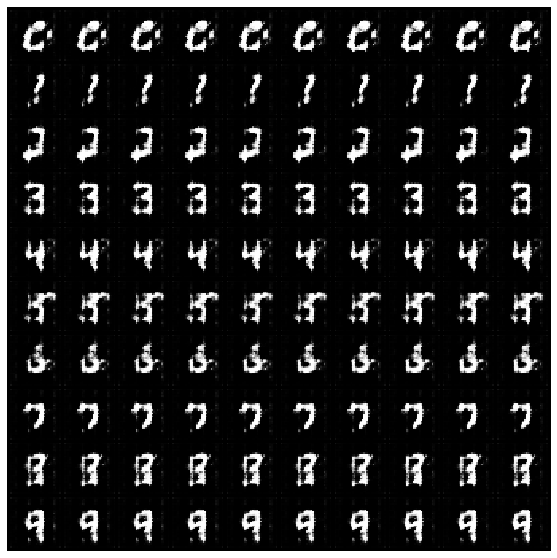

In [0]:
for i in range(steps):
    
    if i == steps_per_epoch * 11:
        optimizerG.param_groups[0]['lr'] /= 10
        optimizerD.param_groups[0]['lr'] /= 10
        print("learning rate change!")
        
    if i == steps_per_epoch * 16:
        optimizerG.param_groups[0]['lr'] /= 10
        optimizerD.param_groups[0]['lr'] /= 10
        print("learning rate change!")
    
    ########
    # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    for _ in range(nb_update_D):
        netD.zero_grad()
        
        # Create batches
        x_real, y_real, r_real = get_batch_real()
        x_fake, y_fake, r_fake = get_batch_fake(y_real)
        
        # Forward 
        r_hat_real = netD(x_real,y_real) # TODO
        r_hat_fake = netD(x_fake,y_fake) # TODO
        errD = criterion(r_hat_real,r_real)+ criterion(r_hat_fake,r_fake) # TODO sum of criterion of real and fake samples
        
        # Backward
        # TODO backward & optimization step on D
        errD.backward()
        optimizerD.step()
        # Compute / save metrics
        avg_output_for_real = r_hat_real.mean().item()
        avg_output_for_fake = r_hat_fake.mean().item()    
        D_losses.append(errD.item())



    ########
    # Update G network: maximize log(D(G(z)))
    for _ in range(nb_update_G):
        netG.zero_grad()
        x_fake, y_fake, r_real = get_batch_fake(y_real,train_G=True)
        # TODO: forward + backward
        # NOTE: use errG as name for your loss variable, like errD above
        r_hat_fake = netD(x_fake,y_fake) 
        # TODO: forward + backward
        errG=criterion(r_hat_fake,r_real)
        # NOTE: use errG as name for your loss variable, like errD above
        errG.backward()
        optimizerG.step()
        # Compute / save metrics
        G_losses.append(errG.item())
        
    
    ########
    # Logs
    if i % 25 == 0:
        print('[%5d/%5d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
              % (i, steps, errD.item(), errG.item(), avg_output_for_real, avg_output_for_fake))

    if i % 100 == 0:
        with torch.no_grad():
            x_fake = netG(fixed_noise, fixed_y).detach().cpu()
        img_list.append(vutils.make_grid(x_fake, padding=2, normalize=True, nrow=10))
        plt.figure(figsize=(10,10))
        plt.imshow(np.transpose(img_list[-1],(1,2,0)))
        plt.axis("off")
        plt.show()

# Display training evolution

In [0]:
# Show generations
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [0]:
# Loss evolution
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("Generator Trainig Loss")
plt.plot(G_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.subplot(2,1,2)
plt.title("Generator Trainig Loss")
plt.plot(D_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()